In [1]:
from eden.converter.rna.rnafold import rnafold_to_eden
from eden.converter.fasta import fasta_to_sequence
from eden.graph import Vectorizer
from itertools import islice
import numpy as np
from scipy.sparse import vstack
%matplotlib inline
%load_ext memory_profiler
from bioinf_learn.util import measure_performance
from bioinf_learn.util import plotData

import time
import numpy as np

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)

def rfam_to_matrix(rfam_id, n_max=50, complexity=2, nbits=10):
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    seqs = islice(seqs,n_max)
    seqs = list(seqs)
    graphs = rnafold_to_eden(seqs)
    vectorizer = Vectorizer(complexity=complexity, nbits=nbits, positional=True)
    X = vectorizer.transform(graphs)
    return X

def rfam_data(rfam_ids, n_max=300, complexity=3, nbits=13):
    Xs = []
    targets = []
    for i,rfam_id in enumerate(rfam_ids):
        X=rfam_to_matrix(rfam_id, n_max=n_max, complexity=complexity, nbits=nbits)
        Xs.append(X)
        targets += [i] * X.shape[0]
    data_matrix = vstack(Xs, format="csr")
    targets = np.array(targets)    
    return data_matrix, targets

In [2]:
rfam_ids=['RF00004','RF00005','RF00015','RF00020','RF00026','RF00169',
          'RF00380','RF00386','RF01051','RF01055','RF01234','RF01699',
          'RF01701','RF01705','RF01731','RF01734','RF01745','RF01750',
          'RF01942','RF01998','RF02005','RF02012','RF02034']

In [3]:
%%time
X, y = rfam_data(rfam_ids[:3], n_max=100, complexity=3, nbits=16)
print 'Instances: %d Features: %d with an avg of %d features per instance' % (X.shape[0], X.shape[1],  X.getnnz()/X.shape[0])
print "Sparsity: ", X.nnz / float(X.shape[0]) / X.shape[1]

Instances: 300 Features: 65537 with an avg of 3914 features per instance
Sparsity:  0.0597250916785
CPU times: user 13.7 s, sys: 1.5 s, total: 15.2 s
Wall time: 20.9 s


In [4]:
from sklearn.neighbors import NearestNeighbors
brute_force = NearestNeighbors()
brute_force.fit(X)
brute_force.kneighbors()

(array([[ 1.01007672,  1.04284466,  1.12198897,  1.12636236,  1.1626469 ],
        [ 0.90830352,  0.96572798,  1.05021041,  1.05297645,  1.05317488],
        [ 1.01007672,  1.10832803,  1.12255392,  1.13476606,  1.16621362],
        ..., 
        [ 1.17007599,  1.1721789 ,  1.17319411,  1.17522851,  1.17582672],
        [ 1.17734409,  1.18059487,  1.18221723,  1.18303139,  1.18352017],
        [ 1.16776601,  1.17636773,  1.1779154 ,  1.17814852,  1.18001481]]),
 array([[  2,  14,  81,  72,   4],
        [  4,  34,  12,  11,  10],
        [  0,  83,  95,  72,  61],
        ..., 
        [282,  48,  49,  54,  65],
        [226, 261, 218, 256,  33],
        [ 48,  94,   9,  81,   6]]))

### Optimized minHash for accuracy >= 0.95
Parameters are taken from the hyperparameter optimization with the bursi dataset

In [4]:
n_neighbors = 10
max_bin_size= 45
shingle_size = 1
similarity=False
number_of_cores=4
prune_inverse_index=14
store_value_with_least_sigificant_bit=0
excess_factor=10
prune_inverse_index_after_instance=0.0
remove_hash_function_with_less_entries_as=0
shingle=0
block_size=1
minHashOptimal = [n_neighbors, max_bin_size, shingle_size, similarity, number_of_cores, 
        prune_inverse_index, store_value_with_least_sigificant_bit, 
        excess_factor, prune_inverse_index_after_instance, 
        remove_hash_function_with_less_entries_as, shingle, block_size]

In [5]:
n_neighbors_sklearn = 10
n_neighbors_minHash = 10
returnValuesRNA = measure_performance(X, minHashOptimal, n_neighbors_sklearn, n_neighbors_minHash, 
                                    number_of_hashfunctions=[100, 200, 400, 600, 800, 1000], 
                                    size_of_query=None)

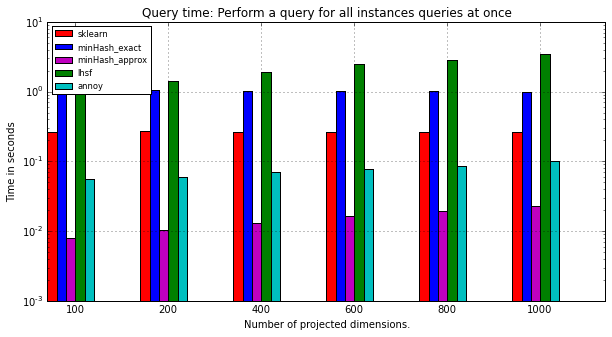

In [6]:
plotData(data=returnValuesRNA[4:9], color=["r", "b", "m", "g", "c"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"], ylabel="Time in seconds", number_of_instances=6,
        xlabel="Number of projected dimensions.",
         number_of_features=1, title='Query time: Perform a query for all instances queries at once')

#### One query to get the nearest neighbors of all instances.
 * MinHash Fast is the fastes algorithm
 * MinHash is over a magnitude slower than the brute force algorithm
 * MinHash performce bad for not that high dimensional and not that sparse datasets. About 65000 dimensions and 3900 non-zero features. Sparsity factor: 0.059

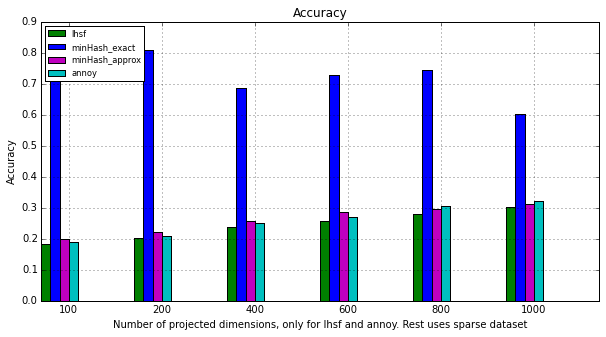

In [7]:
plotData(data=returnValuesRNA[9:], color=["g", "b", "m", "c"], label=["lhsf", "minHash_exact", "minHash_approx", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"],
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Accuracy", number_of_instances=6,
        number_of_features=1, title='Accuracy', log=False)

* Accuracy level of 0.95 for MinHash is not reached, only 0.85 - 0.90
* MinHash Fast is more accurate than LSHF and annoy except for dim >= 800: annoy is more accurate

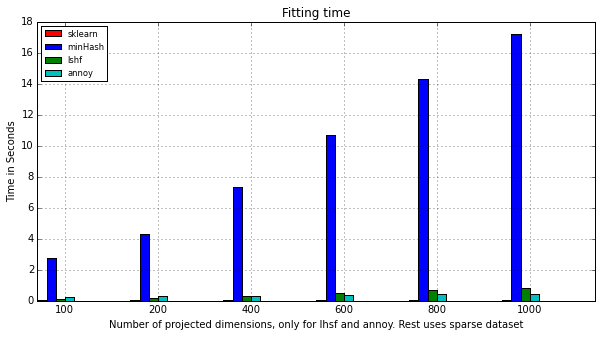

In [8]:
plotData(data=returnValuesRNA[:4], color=["r", "b", "g", "c"], label=["sklearn", "minHash", "lshf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"], 
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Time in Seconds", number_of_instances=6,
        number_of_features=1, title='Fitting time', log=False)

* Fitting time from MinHash is by far the most time consuming

### Optimized for accuracy >= 0.9

In [13]:
n_neighbors = 10
max_bin_size= 86
shingle_size = 1
similarity=False
number_of_cores=4
prune_inverse_index=10
store_value_with_least_sigificant_bit=3
excess_factor=5
prune_inverse_index_after_instance=1.0
remove_hash_function_with_less_entries_as=0
shingle=0
block_size=1
minHashNinety = [n_neighbors, max_bin_size, shingle_size, similarity, number_of_cores, 
        prune_inverse_index, store_value_with_least_sigificant_bit, 
        excess_factor, prune_inverse_index_after_instance, 
        remove_hash_function_with_less_entries_as, shingle, block_size]

In [14]:
n_neighbors_sklearn = 10
n_neighbors_minHash = 10
returnValuesRNA = measure_performance(X, minHashNinety, n_neighbors_sklearn, n_neighbors_minHash, 
                                    number_of_hashfunctions=[100, 200, 400, 600, 800, 1000], 
                                    size_of_query=None)

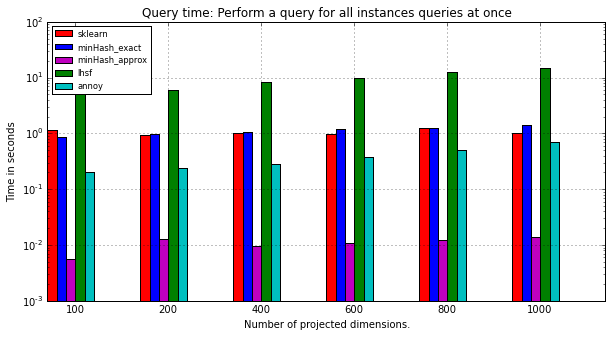

In [15]:
plotData(data=returnValuesRNA[4:9], color=["r", "b", "m", "g", "c"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"], ylabel="Time in seconds", number_of_instances=6,
        xlabel="Number of projected dimensions.",
         number_of_features=1, title='Query time: Perform a query for all instances queries at once')

#### One query to get the nearest neighbors of all instances.
 * MinHash Fast is by far the fastest algorithm
 * MinHash is still slower than the brute force algorithm

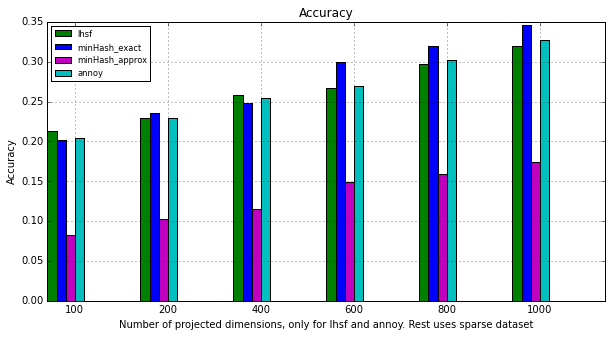

In [16]:
plotData(data=returnValuesRNA[9:], color=["g", "b", "m", "c"], label=["lhsf", "minHash_exact", "minHash_approx", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"],
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Accuracy", number_of_instances=6,
        number_of_features=1, title='Accuracy', log=False)

* Accuracy level of 0.9 is not reached, only about 0.8
* Annoy is always better than MinHash Fast

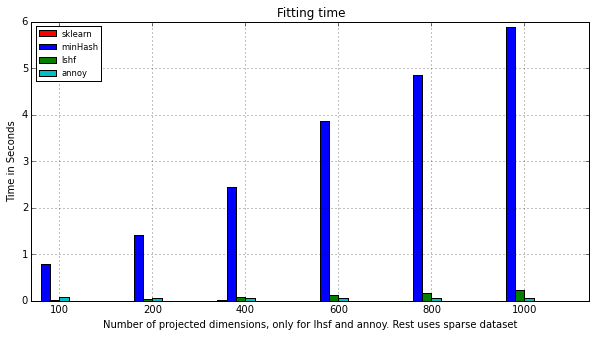

In [14]:
plotData(data=returnValuesRNA[:4], color=["r", "b", "g", "c"], label=["sklearn", "minHash", "lshf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"], 
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Time in Seconds", number_of_instances=6,
        number_of_features=1, title='Fitting time', log=False)

* Fitting time from MinHash is by far the most time consuming

### Optimized for accuracy >= 0.7

In [25]:
n_neighbors = n_neighbors_minHash
max_bin_size= 54
shingle_size = 4
similarity=False
number_of_cores=4
prune_inverse_index=0
store_value_with_least_sigificant_bit=1
excess_factor=8
prune_inverse_index_after_instance=0.0
remove_hash_function_with_less_entries_as=-1
shingle=1
block_size=4
minHashSeventy = [n_neighbors, max_bin_size, shingle_size, similarity, number_of_cores, 
        prune_inverse_index, store_value_with_least_sigificant_bit, 
        excess_factor, prune_inverse_index_after_instance, 
        remove_hash_function_with_less_entries_as, shingle, block_size]

In [26]:
n_neighbors_sklearn = 10
n_neighbors_minHash = 10
returnValuesRNA = measure_performance(X, minHashSeventy, n_neighbors_sklearn, n_neighbors_minHash, 
                                    number_of_hashfunctions=[100, 200, 400, 600, 800, 1000], 
                                    size_of_query=None)

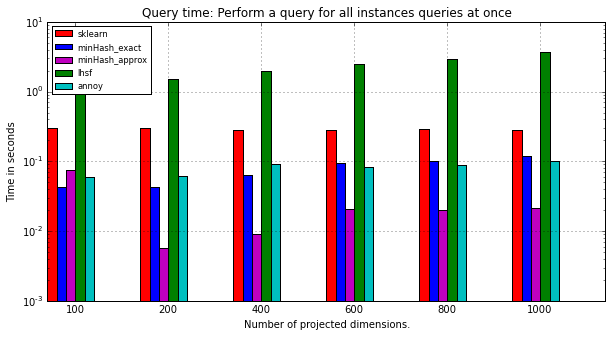

In [27]:
plotData(data=returnValuesRNA[4:9], color=["r", "b", "m", "g", "c"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"], ylabel="Time in seconds", number_of_instances=6,
        xlabel="Number of projected dimensions.",
         number_of_features=1, title='Query time: Perform a query for all instances queries at once')

 * MinHash Fast is now the fastes algorithm
 * MinHash is the first time faster than the brute force and at the same level as annoy

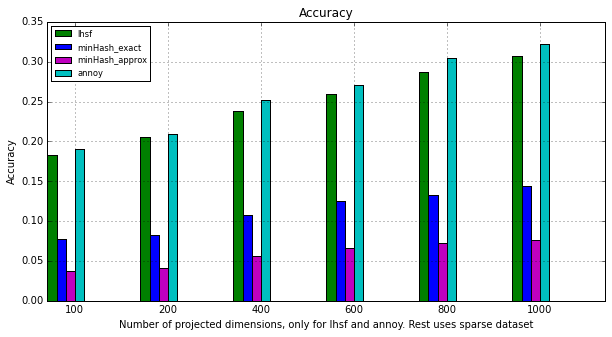

In [28]:
plotData(data=returnValuesRNA[9:], color=["g", "b", "m", "c"], label=["lhsf", "minHash_exact", "minHash_approx", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"],
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Accuracy", number_of_instances=6,
        number_of_features=1, title='Accuracy', log=False)

* Accuracy of MinHash and MinHash Fast is worse than lshf and annoy.
* Level of 0.7 is not reached.

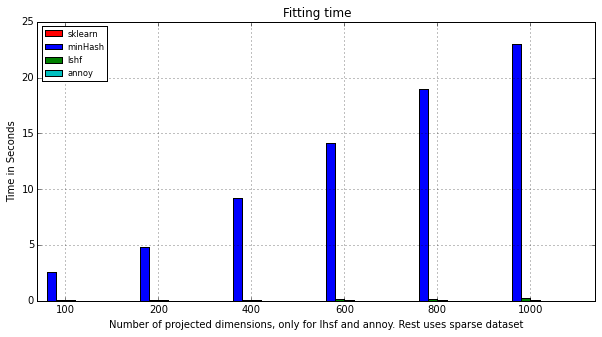

In [29]:
plotData(data=returnValuesRNA[:4], color=["r", "b", "g", "c"], label=["sklearn", "minHash", "lshf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"], 
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Time in Seconds", number_of_instances=6,
        number_of_features=1, title='Fitting time', log=False)

* Fitting time from MinHash is by far the most time consuming

---